In [1]:
import pandas as pd
import numpy as np
import glob

In [2]:
df = pd.DataFrame()
for dataset in ['eeg', 'qsar', 'arcene']:
    for missingness in ['mcar', 'mnar', 'mar']:
        this_df = pd.read_csv(f'{dataset}/{missingness}_runtime_table.csv')
        this_df['dataset'] = dataset
        this_df['missingness'] = missingness
        df = pd.concat([df, this_df])

In [3]:
#df.to_csv('all_runtimes.csv')
ALGO_PLOT_ORDER = ['mean','median','softimpute','matrix','knn','mice','sudoku'] 
ALGO_PLOT_ORDER.reverse()
ALGO_PLOT_ORDER

['sudoku', 'mice', 'knn', 'matrix', 'softimpute', 'median', 'mean']

In [23]:
df[df['dataset'] == 'eeg']

,MP,sudoku,median,mean,matrix,mice,softimpute,knn,dataset,missingness
0,0.1,31.6928,0.0155,0.0035,0.5192,3.4866,1.0605,9.3497,eeg,mcar
1,0.2,52.8672,0.0146,0.0038,0.4257,20.7653,1.3797,12.8949,eeg,mcar
2,0.3,82.9917,0.0150,0.0044,0.5325,16.7733,1.1665,16.6071,eeg,mcar
3,0.4,464.8672,0.0165,0.0056,0.5614,17.9237,1.2863,21.2298,eeg,mcar
4,0.5,408.4185,0.0145,0.0051,0.4055,7.4363,1.1435,24.5569,eeg,mcar
0,0.1,9.2386,0.0150,0.0033,0.3069,19.4223,1.0435,1.7821,eeg,mnar
1,0.2,11.3148,0.0215,0.0029,0.1878,16.9727,1.4483,3.3904,eeg,mnar
2,0.3,17.6142,0.0145,0.0031,0.0539,17.6931,1.0067,5.9343,eeg,mnar
3,0.4,59.9883,0.0141,0.0030,0.3663,17.2905,1.1704,7.6388,eeg,mnar
4,0.5,73.0872,0.0138,0.0030,0.0717,17.8392,1.7625,6.1929,eeg,mnar


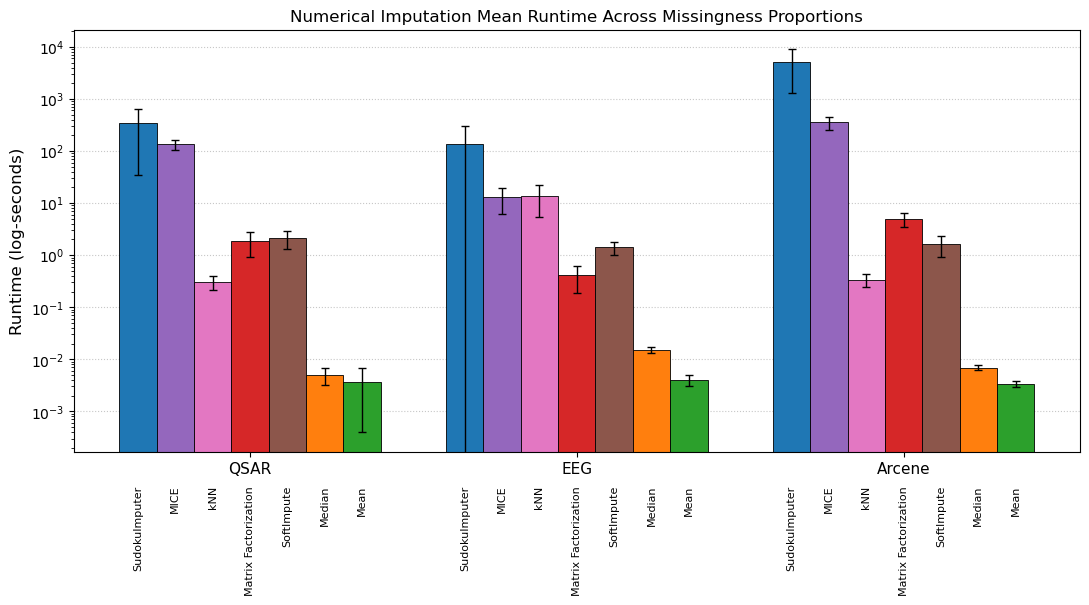

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
ALGO_ORDER = ['sudoku', 'median', 'mean', 'matrix', 'mice', 'softimpute', 'knn']
DATASET_ORDER = ['qsar', 'eeg', 'arcene']  # x-axis group order
ALGO_PLOT_ORDER = ['mean','median','softimpute','matrix','knn','mice','sudoku']  # desired bar order
ALGO_PLOT_ORDER.reverse()

# Display names
ALGO_DISPLAY = {
    'sudoku': 'SudokuImputer',
    'median': 'Median',
    'mean': 'Mean',
    'matrix': 'Matrix Factorization',
    'mice': 'MICE',
    'softimpute': 'SoftImpute',
    'knn': 'kNN'
}
DATASET_DISPLAY = {'eeg': 'EEG', 'qsar': 'QSAR', 'arcene': 'Arcene'}

# Fixed colors for algorithms
TAB10 = plt.get_cmap('tab10')
ALGO_COLORS = {algo: TAB10(i % 10) for i, algo in enumerate(ALGO_ORDER)}

# --------- reshape wide -> long ----------
long = df.melt(
    id_vars=['dataset', 'missingness', 'MP'],
    value_vars=ALGO_ORDER,
    var_name='algorithm',
    value_name='runtime'
)

# --------- aggregate across the 5 proportions (spread over MP) ----------
agg = (long
       .groupby(['dataset', 'algorithm'])['runtime']
       .agg(mean='mean', sd='std')
       .reset_index())

# keep only desired orderings
agg = agg[agg['dataset'].isin(DATASET_ORDER) & agg['algorithm'].isin(ALGO_ORDER)]

# --------- plotting: grouped bars ----------
fig, ax = plt.subplots(figsize=(11, 6.2))

x = np.arange(len(DATASET_ORDER))  # group centers
n_algos = len(ALGO_PLOT_ORDER)
bar_width = 0.8 / n_algos
offsets = (np.arange(n_algos) - (n_algos - 1) / 2) * bar_width

ymin, ymax = ax.get_ylim()
label_y = ymin / 1.5   # push text a bit below the lowest tick

for j, algo in enumerate(ALGO_PLOT_ORDER):
    c = ALGO_COLORS[algo]
    sub = agg[agg['algorithm'] == algo].set_index('dataset').reindex(DATASET_ORDER)

    means = sub['mean'].to_numpy()
    sds   = sub['sd'].to_numpy()
    xpos = x + offsets[j]

    # Bars
    bars = ax.bar(xpos, means, width=bar_width, color=c, edgecolor='black',
                  linewidth=0.6, zorder=2)

    # Error bars (mean ± SD)
    ax.errorbar(xpos, means, yerr=sds, fmt='none', ecolor='black',
                elinewidth=1.0, capsize=3, zorder=3)
    
    # Label each bar *below* (on x-axis)
    for xi in xpos:
        ax.text(xi, -0.08, ALGO_DISPLAY.get(algo, algo),
                ha='center', va='top', fontsize=8, rotation=90,
                transform=ax.get_xaxis_transform(), clip_on=False)

# X axis: dataset group labels
ax.set_xticks(x)
ax.set_xticklabels([DATASET_DISPLAY[d] for d in DATASET_ORDER], fontsize=11)

# Y axis: log scale
ax.set_yscale('log')
ax.set_ylabel('Runtime (log-seconds)', fontsize=12)
#ax.set_xlabel('Experimental dataset', fontsize=12)

# Grid & aesthetics
ax.grid(True, axis='y', linestyle=':', linewidth=0.8, alpha=0.7, zorder=0)
ax.set_axisbelow(True)

# Remove legend (labels are on bars now)
ax.legend_.remove() if ax.get_legend() else None

ax.set_title('Numerical Imputation Mean Runtime Across Missingness Proportions',
             fontsize=12)

plt.tight_layout()

plt.savefig('../../results_figures/comparison/runtime_barplot.png')
plt.savefig('../../results_figures/comparison/runtime_barplot.svg')
plt.show()


In [5]:
summary_table = agg.pivot(index="algorithm", columns="dataset", values="mean")
summary_table['cross_dataset_mean_runtime'] = summary_table.mean(axis=1)
summary_table = summary_table.rename(columns=DATASET_DISPLAY)
summary_table = summary_table.sort_values(by='cross_dataset_mean_runtime', ascending=False)[['EEG', 'QSAR', 'Arcene']].T
summary_table = summary_table.rename(columns=ALGO_DISPLAY)
summary_table

algorithm,SudokuImputer,MICE,kNN,Matrix Factorization,SoftImpute,Median,Mean
dataset,,,,,,,
EEG,138.596273,12.983153,13.888713,0.407480,1.409613,0.015027,0.003987
QSAR,337.956333,134.293073,0.302187,1.851727,2.097840,0.005047,0.003647
Arcene,5212.768020,353.707333,0.333973,4.897487,1.634687,0.006840,0.003387


In [6]:
summary_table.to_csv('summary_table.csv')

In [7]:
long[(long['algorithm'] == 'sudoku') & (long['MP'] == 0.1) & (long['dataset'] == 'eeg')].sort_values(by='runtime')

,dataset,missingness,MP,algorithm,runtime
5,eeg,mnar,0.1,sudoku,9.2386
10,eeg,mar,0.1,sudoku,24.9430
0,eeg,mcar,0.1,sudoku,31.6928
